In [581]:
import mxnet as mx
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock, StochasticSequential
import numpy as onp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import celluloid
npx.set_np()

In [585]:
N = 5000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality
sigma=1.0

x_train = np.zeros((D, N))
w = np.random.normal(0.0, 2.0, size=(D, K))
z = np.random.normal(0.0, 1.0, size=(K, N))
mean = np.dot(w, z)
for d in range(D):
    for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma)
print("True principal axes:")
print(w)



True principal axes:
[[-0.08682507]
 [ 5.369903  ]]


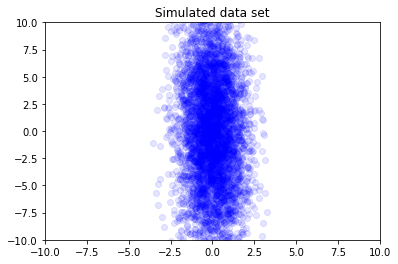

In [586]:
plt.scatter(x_train[0, :].asnumpy(), x_train[1, :].asnumpy(), color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set")
plt.show()

Given $\mathbf{X} = \{\mathbf{x}_n\}, \mathbf{x}_n \in \mathbb{R}^D$ and $\mathbf{z}_n \in \mathbf{R}^K$ with $K < D$, the generative is defined as:


$$
\begin{align*}
p(\mathbf{z}_n) &\sim N(\mathbf{0}, \mathbf{I}) \\
p(W) &\sim N(\mathbf{0}, \mathbf{I}) \\
p(\mathbf{x}_n \mid \mathbf{z}_n) &\sim N(W \mathbf{z}_n, \sigma^2 \mathbf{I}) 
\end{align*}
$$
where $W \in \mathbb{R}^{D \times K}$.

The evidence lower bound is defined as follow:
$$
\begin{align*}
\mathcal{L(\phi, \theta)} 
&= \mathbb{E}_{q(w, z \mid \phi,\theta)}\left( \ln p(x, w, z) - \ln q(w, z \mid \phi, \theta) \right) \\
&= \mathbb{E}_{q(w, z \mid \phi, \theta)}\left( \ln \frac{p(w)}{q(w | \phi)} + \ln \frac{p(z)}{q(z | \theta)} + \ln p(x \mid w, z) \right).
\end{align*}
$$

In [666]:
def ELBO(x, qw, qz, pw, pz, sample_size=50):
    """
    x: observed samples
    qw: variational posterior for `W`
    qz: variational posterior for `z`
    pw: prior of `W`
    pz: prior of `z`
    sample_size: number of sample for stochastic gradient estimation
    """
    samples_w = qw.sample_n(sample_size) # (sample_size, D, K)
    samples_z = qz.sample_n(sample_size) # (sampe_size, N, K)
    px_wz = mgp.Normal(loc=np.matmul(samples_w, np.swapaxes(samples_z, -1, -2)), scale=1.0)
    kl_w = pw.log_prob(samples_w) - qw.log_prob(samples_w)
    kl_z = pz.log_prob(samples_z) - qz.log_prob(samples_z)
    ll = px_wz.log_prob(x).mean(0).mean()
    return (10.0 * ll + kl_w.mean(0).sum() / 5000 + kl_z.mean(0).mean()) 
    # The weight before each term shouldn't be this arbitary, but this is the only way to make it work =_=
    # Should be fixed in the future.

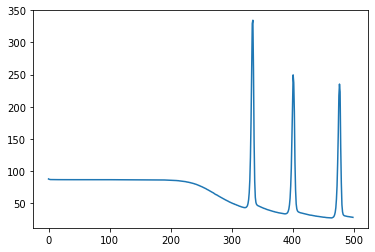

In [667]:
def gd(params, lr):
    for t in params:
        t -= lr * t.grad
        
def softplus(value):
    return np.log1p(np.exp(value))

num_iter = 500
lr = 0.5
params = []
# random initialization
loc_w = np.zeros((D, K))
log_scale_w = np.zeros((D, K))
loc_z = np.zeros((N, K))
log_scale_z = np.zeros((N, K))
params.append(loc_w)
params.append(log_scale_w)
params.append(loc_z)
params.append(log_scale_z)
for p in params:
    p.attach_grad()

loss_train = []
for iter in range(num_iter):
    with autograd.record():
        qw = mgp.Normal(loc_w, softplus(log_scale_w))
        qz = mgp.Normal(loc_z, softplus(log_scale_z))
        loss = -ELBO(x_train, qw, qz, mgp.Normal(0, 1), mgp.Normal(0, 1))
    loss.backward()
    gd(params, lr)
    loss_train.append(loss.asnumpy())
plt.plot(loss_train)

In [668]:
print("Inferred principal axes:")
print(loc_w)

Inferred principal axes:
[[ 0.0893291]
 [-5.798397 ]]


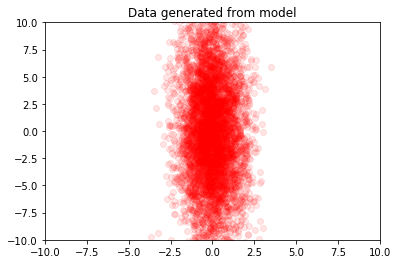

In [669]:
#
qw = mgp.Normal(loc_w, softplus(log_scale_w))
qz = mgp.Normal(loc_z, softplus(log_scale_z))
samples_w = qw.sample()
samples_z = qz.sample()
px_wz = mgp.Normal(loc=np.matmul(samples_w, np.swapaxes(samples_z, -1, -2)), scale=1.0)
px_recon = px_wz.sample()
plt.scatter(px_recon[0, :].asnumpy(), px_recon[1, :].asnumpy(), color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()